In [ ]:
# main imports
import os
import sys
import ast
import glob
import math
import shutil
import random
import importlib
import subprocess

import numpy as np
import pandas as pd

from itertools import product

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import seaborn as sns
from joypy import joyplot

plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 24
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 1

sys.path.insert(0, "/ccb/salz8-1/avaraby/orfanage/soft")
%aimport definitions

In [3]:
# paths

base_dir = "/ccb/salz8-1/avaraby/orfanage/"

orfanage_bin = base_dir+"bin/orfanage"
gffcompare_bin = "/ccb/salz7-data/sw2/bin/gffcompare"
gffread_bin = "/ccb/salz7-data/sw2/bin/gffread"
igvtools_bin = "/ccb/salz7-data/sw/bin/igvtools"
sashimi_bin = base_dir+"bin/sashimi.py"

fa_fname = base_dir+"data/hg38.fa"
gtf_fname = base_dir+"data/gencode.v41.gtf"
mane_gtf_fname = base_dir+"data/MANE.v10.gtf"

gencode_outdir = base_dir+"gencode/"
if not os.path.exists(gencode_outdir):
    os.makedirs(gencode_outdir)

In [4]:
# arguments
num_threads = 30

In [5]:
gtf_adjstop_fname = gtf_fname.rsplit(".",1)[0]+".adjstop.gtf"
gtf_adjstop_sorted_fname = gtf_adjstop_fname.rsplit(".",1)[0]+".sorted.gtf"
gtf_adjstop_aa_fa_fname = gtf_adjstop_fname.rsplit(".",1)[0]+".aa.fa"

clean_gtf_fname = gtf_adjstop_fname.rsplit(".",1)[0]+".clean.gtf"
nocds_gtf_fname = clean_gtf_fname.rsplit(".",1)[0]+".nocds.gtf"

out_gtf_fname = gencode_outdir+"orf.gtf"
out_stats_fname = gencode_outdir+"orf.stats"
out_gtf_sorted_fname = out_gtf_fname.rsplit(".",1)[0]+".sorted.gtf"

out_df_tsv_fname = gencode_outdir+"df.tsv"

In [6]:
# standardize the annotation - adjust stop, discard anything without a start/stop codon
cmd = [gffread_bin,
       "-g",fa_fname,
       "--adj-stop","-T","-F","-J",
       "-o",gtf_adjstop_fname,
       gtf_fname]

print(" ".join(cmd))
subprocess.call(cmd)

igv_cmd = [igvtools_bin,"sort",gtf_adjstop_fname,gtf_adjstop_sorted_fname]
print(" ".join(igv_cmd))
subprocess.call(igv_cmd)
igv_cmd = [igvtools_bin,"index",gtf_adjstop_sorted_fname]
print(" ".join(igv_cmd))
subprocess.call(igv_cmd)

cmd = [gffread_bin,
       "-y",gtf_adjstop_aa_fa_fname,
       "-g",fa_fname,
       gtf_adjstop_fname]

print(" ".join(cmd))
subprocess.call(cmd)

/ccb/salz7-data/sw2/bin/gffread -g /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --adj-stop -T -F -J -o /ccb/salz8-1/avaraby/orfanage/data/gencode.v41.adjstop.gtf /ccb/salz8-1/avaraby/orfanage/data/gencode.v41.gtf


/ccb/salz7-data/sw/bin/igvtools sort /ccb/salz8-1/avaraby/orfanage/data/gencode.v41.adjstop.gtf /ccb/salz8-1/avaraby/orfanage/data/gencode.v41.adjstop.sorted.gtf
Sorting /ccb/salz8-1/avaraby/orfanage/data/gencode.v41.adjstop.gtf  -> /ccb/salz8-1/avaraby/orfanage/data/gencode.v41.adjstop.sorted.gtf


Snappy is disabled via system property.


Done
/ccb/salz7-data/sw/bin/igvtools index /ccb/salz8-1/avaraby/orfanage/data/gencode.v41.adjstop.sorted.gtf
Done
/ccb/salz7-data/sw2/bin/gffread -y /ccb/salz8-1/avaraby/orfanage/data/gencode.v41.adjstop.aa.fa -g /ccb/salz8-1/avaraby/orfanage/data/hg38.fa /ccb/salz8-1/avaraby/orfanage/data/gencode.v41.adjstop.gtf


0

In [7]:
# get ids to remove
# 1. seleno
# 2. polycistronic
# 3. other

# polycistronic
df = definitions.get_chains(gtf_fname,"CDS",True)
df = df[df["has_cds"]==1].reset_index(drop=True)
df["seqid"]=df["coords"].str.split(":",n=1,expand=True)[0]
df["start"] = df["chain"].apply(lambda row: row[0][0])
df["end"] = df["chain"].apply(lambda row: row[-1][1])
# add gene ids
gid=pd.read_csv(gtf_fname,sep="\t",names=definitions.gff3cols,comment="#")
gid=gid[gid["type"]=="transcript"].reset_index(drop=True)
gid["tid"]=gid["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
gid["gid"]=gid["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
gid = gid[["gid","tid"]]
print("total number of genes: "+str(len(set(gid["gid"]))))

df = df.merge(gid,on="tid",how="left",indicator=False)

print("total number of coding genes: "+str(len(set(df["gid"]))))

df["start"] = df["start"].astype(int)
df["end"] = df["end"].astype(int)

df.sort_values(by=["seqid","strand","start","end"],ascending=True,inplace=True)

df = df.groupby(by=["seqid","strand","gid"]).agg({"start":min,"end":max}).reset_index()
df.sort_values(by=["seqid","strand","start","end"],ascending=True,inplace=True)
df["nc"]=df.seqid.shift(-1)
df["nt"]=df.strand.shift(-1)
df["ns"]=df.start.shift(-1)
df["nid"]=df.gid.shift(-1)
df.fillna(0,inplace=True)
df["od"] = np.where((df["seqid"]==df["nc"]) & 
                           (df["strand"]==df["nt"]) & 
                           (df["end"]>df["ns"]),1,0)
pids = set(df[df["od"]==1]["gid"]).union(set(df[df["od"]==1]["nid"]))
print("number of poly: "+str(len(pids)))

# seleno and other exceptions

df=pd.read_csv(gtf_fname,sep="\t",names=definitions.gff3cols,comment="#")
df=df[df["type"]=="transcript"].reset_index(drop=True)
df["tid"]=df["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
df["gid"]=df["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
df["seleno"] = df["attributes"].str.lower().str.contains("selen")

sids = set(df[df["seleno"]]["gid"])
print("number of seleno: "+str(len(sids)))

total number of genes: 61852
total number of coding genes: 20427
number of poly: 1838
number of seleno: 34


In [8]:
dirty_gids = pids.union(sids)
print("number of genes to discard: "+str(len(dirty_gids)))

number of genes to discard: 1869


In [9]:
# create a file without transcripts in these genes
with open(clean_gtf_fname,"w+") as outFP:
    with open(gtf_adjstop_fname,"r") as inFP:
        for line in inFP:
            lcs = line.split("\t")
            gid = lcs[8].split("gene_id \"",1)[1].split("\"",1)[0]
            if not gid in dirty_gids:
                outFP.write(line)

In [10]:
# create input without CDS in it (easier to explain than "not using --keep_cds")
with open(nocds_gtf_fname,"w+") as outFP:
    with open(clean_gtf_fname,"r") as inFP:
        for line in inFP:
            lcs = line.split("\t")
            if lcs[2]=="CDS":
                continue
            
            outFP.write(line)

In [8]:
# run orfanage on self

cmd = [orfanage_bin,
       "--reference",fa_fname,
       "--query",nocds_gtf_fname,
       "--threads",str(num_threads),
       "--output",out_gtf_fname,
       "--stats",out_stats_fname,
       "--non_aug",
       mane_gtf_fname]
print(" ".join(cmd))
subprocess.call(cmd)

igv_cmd = [igvtools_bin,"sort",out_gtf_fname,out_gtf_sorted_fname]
print(" ".join(igv_cmd))
# subprocess.call(igv_cmd)
igv_cmd = [igvtools_bin,"index",out_gtf_sorted_fname]
print(" ".join(igv_cmd))
# subprocess.call(igv_cmd)

/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/data/gencode.v41.adjstop.clean.nocds.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.gtf --stats /ccb/salz8-1/avaraby/orfanage/gencode/orf.stats --non_aug /ccb/salz8-1/avaraby/orfanage/data/MANE.v10.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz7-data/sw/bin/igvtools sort /ccb/salz8-1/avaraby/orfanage/gencode/orf.gtf /ccb/salz8-1/avaraby/orfanage/gencode/orf.sorted.gtf
/ccb/salz7-data/sw/bin/igvtools index /ccb/salz8-1/avaraby/orfanage/gencode/orf.sorted.gtf


In [12]:
# let's investigate more closely and identify any eggregious examples

# we ran gencode to auto-correct itself with results in out_gtf_fname

# load chains from both and MANE and attach all together

orf_df = definitions.get_chains(out_gtf_fname,"CDS",True)
gtf_df = definitions.get_chains(clean_gtf_fname,"CDS",False)
mane_df = definitions.get_chains(mane_gtf_fname,"CDS",False)
mane_df.rename({"tid":"mane_tid"},axis=1,inplace=True)

gtf_attr = definitions.get_attribute(clean_gtf_fname,"gene_id")
gtf_attr.columns = ["tid","gid"]
mane_attr = definitions.get_attribute(mane_gtf_fname,"gene_id")
mane_attr.columns = ["tid","gid"]

In [14]:
df = orf_df.merge(gtf_df,on="tid",how="outer",indicator=True)
assert len(df[~(df["_merge"]=="both")])==0,"wrong merge"
df.drop("_merge",axis=1,inplace=True)
df.columns = ["tid","has_cds_orf","seqid","strand","coords","chain_orf","has_cds_def","chain_def"]
# now attach gene id information so we can add mane transcripts later
attr_df = gtf_attr.merge(mane_attr,on="gid",how="inner")
attr_df.columns = ["tid","gid","mane_tid"]
attr_df.drop("gid",axis=1,inplace=True)
# merge all together
df = df.merge(attr_df,on="tid",how="inner")
df = df.merge(mane_df,on="mane_tid")
df.columns = ["tid","has_cds_orf","seqid","strand","coords","chain_orf","has_cds_def","chain_def","mane_tid","has_cds_mane","chain_mane"]
df.drop("has_cds_mane",axis=1,inplace=True)

# compare chains
df[["mod_chain_orf",
         "c1len_orf",
         "c2len_orf",
         "match_start_orf",
         "match_end_orf",
         "num_bp_extra_orf",
         "num_bp_missing_orf",
         "num_bp_inframe_orf",
         "num_bp_match_orf",
         "num_bp_outframe_orf",
         "lpd_orf",
         "ilpd_orf",
         "mlpd_orf"]] = df.apply(lambda row: definitions.compare_and_extract(row["chain_orf"],row["chain_mane"],row["strand"]),axis=1)

df[["mod_chain_def",
         "c1len_def",
         "c2len_def",
         "match_start_def",
         "match_end_def",
         "num_bp_extra_def",
         "num_bp_missing_def",
         "num_bp_inframe_def",
         "num_bp_match_def",
         "num_bp_outframe_def",
         "lpd_def",
         "ilpd_def",
         "mlpd_def"]] = df.apply(lambda row: definitions.compare_and_extract(row["chain_def"],row["chain_mane"],row["strand"]),axis=1)

# save
df.to_csv(out_df_tsv_fname,sep="\t",index=False)

df.head()

,tid,has_cds_orf,seqid,strand,coords,chain_orf,has_cds_def,chain_def,mane_tid,chain_mane,mod_chain_orf,c1len_orf,c2len_orf,match_start_orf,match_end_orf,num_bp_extra_orf,num_bp_missing_orf,num_bp_inframe_orf,num_bp_match_orf,num_bp_outframe_orf,lpd_orf,ilpd_orf,mlpd_orf,mod_chain_def,c1len_def,c2len_def,match_start_def,match_end_def,num_bp_extra_def,num_bp_missing_def,num_bp_inframe_def,num_bp_match_def,num_bp_outframe_def,lpd_def,ilpd_def,mlpd_def
0,ENST00000338591.8,1,chr1,+,chr1:960584-965719,"[[960694, 960800], [961293, 961552], [961629, ...",1,"[[960694, 960800], [961293, 961552], [961629, ...",ENST00000338591.8,"[[960694, 960800], [961293, 961552], [961629, ...","[[960694, 960800, 0], [961293, 961552, 0], [96...",1929,1929,True,True,0,0,1929,1929,0,100,100,100,"[[960694, 960800, 0], [961293, 961552, 0], [96...",1929,1929,True,True,0,0,1929,1929,0,100,100,100
1,ENST00000463212.1,1,chr1,+,chr1:961449-962478,"[[961634, 961750], [961826, 962272]]",0,[],ENST00000338591.8,"[[960694, 960800], [961293, 961552], [961629, ...","[[960694, 960800, 1], [961293, 961552, 1], [96...",564,1929,False,False,225,1590,339,339,0,29,17,17,"[[960694, 960800, 1], [961293, 961552, 1], [96...",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,ENST00000481067.1,0,chr1,+,chr1:963552-964164,[],0,[],ENST00000338591.8,"[[960694, 960800], [961293, 961552], [961629, ...","[[960694, 960800, 1], [961293, 961552, 1], [96...",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,"[[960694, 960800, 1], [961293, 961552, 1], [96...",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,ENST00000379410.8,1,chr1,+,chr1:966482-975865,"[[966532, 966614], [966704, 966803], [970277, ...",1,"[[966532, 966614], [966704, 966803], [970277, ...",ENST00000379410.8,"[[966532, 966614], [966704, 966803], [970277, ...","[[966532, 966614, 0], [966704, 966803, 0], [97...",1836,1836,True,True,0,0,1836,1836,0,100,100,100,"[[966532, 966614, 0], [966704, 966803, 0], [97...",1836,1836,True,True,0,0,1836,1836,0,100,100,100
4,ENST00000379407.7,1,chr1,+,chr1:966502-975008,"[[966532, 966614], [966704, 966803], [970277, ...",1,"[[966532, 966614], [966704, 966803], [970277, ...",ENST00000379410.8,"[[966532, 966614], [966704, 966803], [970277, ...","[[966532, 966614, 0], [966704, 966803, 0], [97...",1731,1836,True,True,36,141,1695,1695,0,94,92,92,"[[966532, 966614, 0], [966704, 966803, 0], [97...",1731,1836,True,True,36,141,1695,1695,0,94,92,92


In [15]:
# now let's get down to business

df = pd.read_csv(gencode_outdir+"df.tsv",sep="\t")

print("total number of transcripts "+str(len(df)))

print("number of transcripts with ORF in GENCODE: "+str(len(df[df["has_cds_def"]==1])))
print("number of transcripts without ORF in GENCODE: "+str(len(df[df["has_cds_def"]==0])))

print("number of transcripts with ORF in ORFanage: "+str(len(df[df["has_cds_orf"]==1])))
print("number of transcripts without ORF in ORFanage: "+str(len(df[df["has_cds_orf"]==0])))

print("number of transcripts GENCODE==MANE: "+str(len(df[df["chain_def"]==df["chain_mane"]])))
print("number of transcripts GENCODE!=MANE: "+str(len(df[~(df["chain_def"]==df["chain_mane"])&(df["has_cds_def"]==1)])))

print("number of transcripts ORFanage==MANE: "+str(len(df[df["chain_orf"]==df["chain_mane"]])))
print("number of transcripts ORFanage!=MANE: "+str(len(df[~(df["chain_orf"]==df["chain_mane"])&(df["has_cds_orf"]==1)])))

print("number of transcripts missing ORF in both: "+str(len(df[(df["has_cds_orf"]==0)&(df["has_cds_def"]==0)])))

print("number of transcripts GENCODE==ORFanage==MANE: "+str(len(df[(df["chain_orf"]==df["chain_mane"])&
                                                                  (df["chain_def"]==df["chain_mane"])])))

print("number of transcripts GENCODE!=(ORFanage==MANE): "+str(len(df[(df["chain_orf"]==df["chain_mane"])&
                                                                    ~(df["chain_def"]==df["chain_mane"])&
                                                                    (df["has_cds_def"]==1)])))

print("number of transcripts No ORF GENCODE AND (ORFanage==MANE): "+str(len(df[(df["chain_orf"]==df["chain_mane"])&
                                                                    ~(df["chain_def"]==df["chain_mane"])&
                                                                    (df["has_cds_def"]==0)])))

print("number of transcripts No ORF GENCODE AND (ORFanage!=MANE): "+str(len(df[~(df["chain_orf"]==df["chain_mane"])&
                                                                    (df["has_cds_orf"]==1)&
                                                                    (df["has_cds_def"]==0)])))


print("number of transcripts ORFanage!=(GENCODE==MANE): "+str(len(df[(df["chain_def"]==df["chain_mane"])&
                                                                    ~(df["chain_orf"]==df["chain_mane"])&
                                                                    (df["has_cds_orf"]==1)])))

print("number of transcripts No ORF ORFanage AND (GENCODE==MANE): "+str(len(df[(df["chain_def"]==df["chain_mane"])&
                                                                    ~(df["chain_orf"]==df["chain_mane"])&
                                                                    (df["has_cds_orf"]==0)])))


print("number of transcripts ORFanage != GENCODE= != MANE: "+str(len(df[~(df["chain_def"]==df["chain_mane"])&
                                                                    ~(df["chain_orf"]==df["chain_mane"])&
                                                                    (df["has_cds_def"]==1)&
                                                                    (df["has_cds_orf"]==1)])))

print("Of those number of transcripts (ORFanage == GENCODE) != MANE: "+str(len(df[~(df["chain_def"]==df["chain_mane"])&
                                                                    ~(df["chain_orf"]==df["chain_mane"])&
                                                                    (df["chain_orf"]==df["chain_def"])&
                                                                    (df["has_cds_def"]==1)&
                                                                    (df["has_cds_orf"]==1)])))

print("Of those number of transcripts (ORFanage != GENCODE) != MANE: "+str(len(df[~(df["chain_def"]==df["chain_mane"])&
                                                                    ~(df["chain_orf"]==df["chain_mane"])&
                                                                    ~(df["chain_orf"]==df["chain_def"])&
                                                                    (df["has_cds_def"]==1)&
                                                                    (df["has_cds_orf"]==1)])))

print("number of transcripts No ORFanage AND (GENCODE= != MANE): "+str(len(df[~(df["chain_def"]==df["chain_mane"])&
                                                                    (df["has_cds_def"]==1)&
                                                                    (df["has_cds_orf"]==0)])))

total number of transcripts 128286
number of transcripts with ORF in GENCODE: 72958
number of transcripts without ORF in GENCODE: 55328
number of transcripts with ORF in ORFanage: 108250
number of transcripts without ORF in ORFanage: 20036
number of transcripts GENCODE==MANE: 26306
number of transcripts GENCODE!=MANE: 46652
number of transcripts ORFanage==MANE: 27217
number of transcripts ORFanage!=MANE: 81033
number of transcripts missing ORF in both: 19788
number of transcripts GENCODE==ORFanage==MANE: 26283
number of transcripts GENCODE!=(ORFanage==MANE): 787
number of transcripts No ORF GENCODE AND (ORFanage==MANE): 147
number of transcripts No ORF GENCODE AND (ORFanage!=MANE): 35393
number of transcripts ORFanage!=(GENCODE==MANE): 23
number of transcripts No ORF ORFanage AND (GENCODE==MANE): 0
number of transcripts ORFanage != GENCODE= != MANE: 45617
Of those number of transcripts (ORFanage == GENCODE) != MANE: 37683
Of those number of transcripts (ORFanage != GENCODE) != MANE: 79

In [20]:
# isolate cases where all are different from one another
orfNEmaneNEdef = df[~(df["chain_def"]==df["chain_mane"])&
                    ~(df["chain_orf"]==df["chain_mane"])&
                    ~(df["chain_orf"]==df["chain_def"])&
                    (df["has_cds_def"]==1)&
                    (df["has_cds_orf"]==1)].reset_index(drop=True)

In [21]:
# identify cases where transcript starts at non-zero phase

phased_chains = definitions.get_chains(clean_gtf_fname,"CDS",True,True)
phased_chains = phased_chains[phased_chains["has_cds"]==1].reset_index(drop=True)
def get_start_phase(chain,strand):
    sc = sorted(chain)
    if strand=="+":
        return sc[0][-1]
    else:
        return sc[-1][-1]
phased_chains["start_phase"] = phased_chains.apply(lambda row: get_start_phase(row["chain"],row["strand"]),axis=1)

misphased_tids = set(phased_chains[~(phased_chains["start_phase"]=="0")]["tid"].tolist())
misphased = orfNEmaneNEdef[orfNEmaneNEdef["tid"].isin(misphased_tids)].reset_index(drop=True)
orfNEmaneNEdef = orfNEmaneNEdef[~(orfNEmaneNEdef["tid"].isin(misphased["tid"]))].reset_index(drop=True)
print("number of transcripts with GENCODE start phase!=0: "+str(len(misphased)))

number of transcripts with GENCODE start phase!=0: 127


In [22]:
# plot ilpd and get some good examples

orfNEmaneNEdef["chain_orf"] = orfNEmaneNEdef["chain_orf"].apply(lambda chainstr: ast.literal_eval(chainstr))
orfNEmaneNEdef["chain_def"] = orfNEmaneNEdef["chain_def"].apply(lambda chainstr: ast.literal_eval(chainstr))
orfNEmaneNEdef["chain_mane"] = orfNEmaneNEdef["chain_mane"].apply(lambda chainstr: ast.literal_eval(chainstr))

orfNEmaneNEdef.drop(["mod_chain_orf",
              "c1len_orf",
              "c2len_orf",
              "num_bp_match_orf",
              "lpd_orf",
              "mlpd_orf"],axis=1,inplace=True)

orfNEmaneNEdef.drop(["mod_chain_def",
              "c1len_def",
              "c2len_def",
              "num_bp_match_def",
              "lpd_def",
              "mlpd_def"],axis=1,inplace=True)

orfNEmaneNEdef["ilpd_change"] = orfNEmaneNEdef["ilpd_orf"]-orfNEmaneNEdef["ilpd_def"]
print("number of transcripts with decreased ilpd: "+str(len(orfNEmaneNEdef[orfNEmaneNEdef["ilpd_change"]<0])))
print("number of transcripts with increased ilpd: "+str(len(orfNEmaneNEdef[orfNEmaneNEdef["ilpd_change"]>0])))
print("number of transcripts with unchanged ilpd: "+str(len(orfNEmaneNEdef[orfNEmaneNEdef["ilpd_change"]==0])))

# reasons for lower ilpd
# 1. seleno
# 2. polycistronic
# 3. alternative start/end

orfNEmaneNEdef.sort_values(by="ilpd_change",inplace=True,ascending=False)
orfNEmaneNEdef.to_csv(gencode_outdir+"orfNEmaneNEdef.tsv",index=False,sep="\t")
orfNEmaneNEdef.head()

number of transcripts with decreased ilpd: 16
number of transcripts with increased ilpd: 6881
number of transcripts with unchanged ilpd: 910


,tid,has_cds_orf,seqid,strand,coords,chain_orf,has_cds_def,chain_def,mane_tid,chain_mane,match_start_orf,match_end_orf,num_bp_extra_orf,num_bp_missing_orf,num_bp_inframe_orf,num_bp_outframe_orf,ilpd_orf,match_start_def,match_end_def,num_bp_extra_def,num_bp_missing_def,num_bp_inframe_def,num_bp_outframe_def,ilpd_def,ilpd_change
2641,ENST00000356799.6,1,chr6,+,chr6:127266849-127288567,"[[127286617, 127287693]]",1,"[[127280339, 127280340], [127286050, 127286170]]",ENST00000368314.6,"[[127280339, 127280340], [127286616, 127287693]]",False,True,0,3,1077,0,99,True,False,121,1078,2,0,0,99
979,ENST00000648361.1,1,chr2,+,chr2:206279560-206313196,"[[206292063, 206292116], [206297246, 206297373...",1,"[[206281850, 206281909], [206292011, 206292116...",ENST00000374423.9,"[[206281850, 206281909], [206297246, 206297373...",False,True,54,60,7005,0,99,True,False,106,6961,60,44,0,99
2961,ENST00000395391.2,1,chr7,+,chr7:64666099-64710602,"[[64669161, 64669178], [64691248, 64691374], [...",1,"[[64666283, 64666285], [64669037, 64669178], [...",ENST00000620827.6,"[[64666283, 64666285], [64691248, 64691374], [...",False,True,18,3,2556,0,99,True,False,142,2539,3,17,0,99
3038,ENST00000652054.1,1,chr7,+,chr7:121873161-122061669,"[[121893611, 121893626], [121928156, 121928221...",1,"[[121873500, 121873557], [121893524, 121893626...",ENST00000393386.7,"[[121873500, 121873557], [121928156, 121928221...",False,True,16,58,6890,0,99,True,False,103,6880,58,10,0,99
2639,ENST00000697698.1,1,chr6,+,chr6:116681214-116732806,"[[116681589, 116681634], [116689320, 116689453...",1,"[[116681335, 116681338], [116681493, 116681634...",ENST00000368564.7,"[[116681335, 116681338], [116689320, 116689453...",False,True,46,4,1616,0,99,True,False,142,1603,4,13,0,99


In [23]:
# make figures for the top cases to see if we can find smth good
if not os.path.exists(gencode_outdir+"orfNEmaneNEdef/"):
    os.makedirs(gencode_outdir+"orfNEmaneNEdef/")
    
for idx,row in orfNEmaneNEdef.iterrows():
    qtid = row["tid"]
    mane_tid = row["mane_tid"]
    
    cur_base_fname = gencode_outdir+"orfNEmaneNEdef/"+str(idx)+"_"+qtid
    definitions.extract_sashimi(sashimi_bin,mane_gtf_fname,clean_gtf_fname,gencode_outdir+"orf.gtf",cur_base_fname,mane_tid,qtid,qtid+" "+mane_tid+" "+str(row["ilpd_change"]))

/ccb/salz8-1/avaraby/orfanage/bin/sashimi.py --compare ENST00000368314.6 --title ENST00000356799.6 ENST00000368314.6 99 --gtf /ccb/salz8-1/avaraby/orfanage/gencode/orfNEmaneNEdef/2641_ENST00000356799.6.gtf -o /ccb/salz8-1/avaraby/orfanage/gencode/orfNEmaneNEdef/2641_ENST00000356799.6.svg
/ccb/salz8-1/avaraby/orfanage/bin/sashimi.py --compare ENST00000374423.9 --title ENST00000648361.1 ENST00000374423.9 99 --gtf /ccb/salz8-1/avaraby/orfanage/gencode/orfNEmaneNEdef/979_ENST00000648361.1.gtf -o /ccb/salz8-1/avaraby/orfanage/gencode/orfNEmaneNEdef/979_ENST00000648361.1.svg
/ccb/salz8-1/avaraby/orfanage/bin/sashimi.py --compare ENST00000620827.6 --title ENST00000395391.2 ENST00000620827.6 99 --gtf /ccb/salz8-1/avaraby/orfanage/gencode/orfNEmaneNEdef/2961_ENST00000395391.2.gtf -o /ccb/salz8-1/avaraby/orfanage/gencode/orfNEmaneNEdef/2961_ENST00000395391.2.svg
/ccb/salz8-1/avaraby/orfanage/bin/sashimi.py --compare ENST00000393386.7 --title ENST00000652054.1 ENST00000393386.7 99 --gtf /ccb/salz

total number of genes with CDS in them: 18122
total number of transcript with CDS: 72947
number of genes with multiple coding isoforms: 13492
number of transcripts in genes with multiple coding isoforms: 68317


/ccb/salz8-3/avaraby1/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='count'>

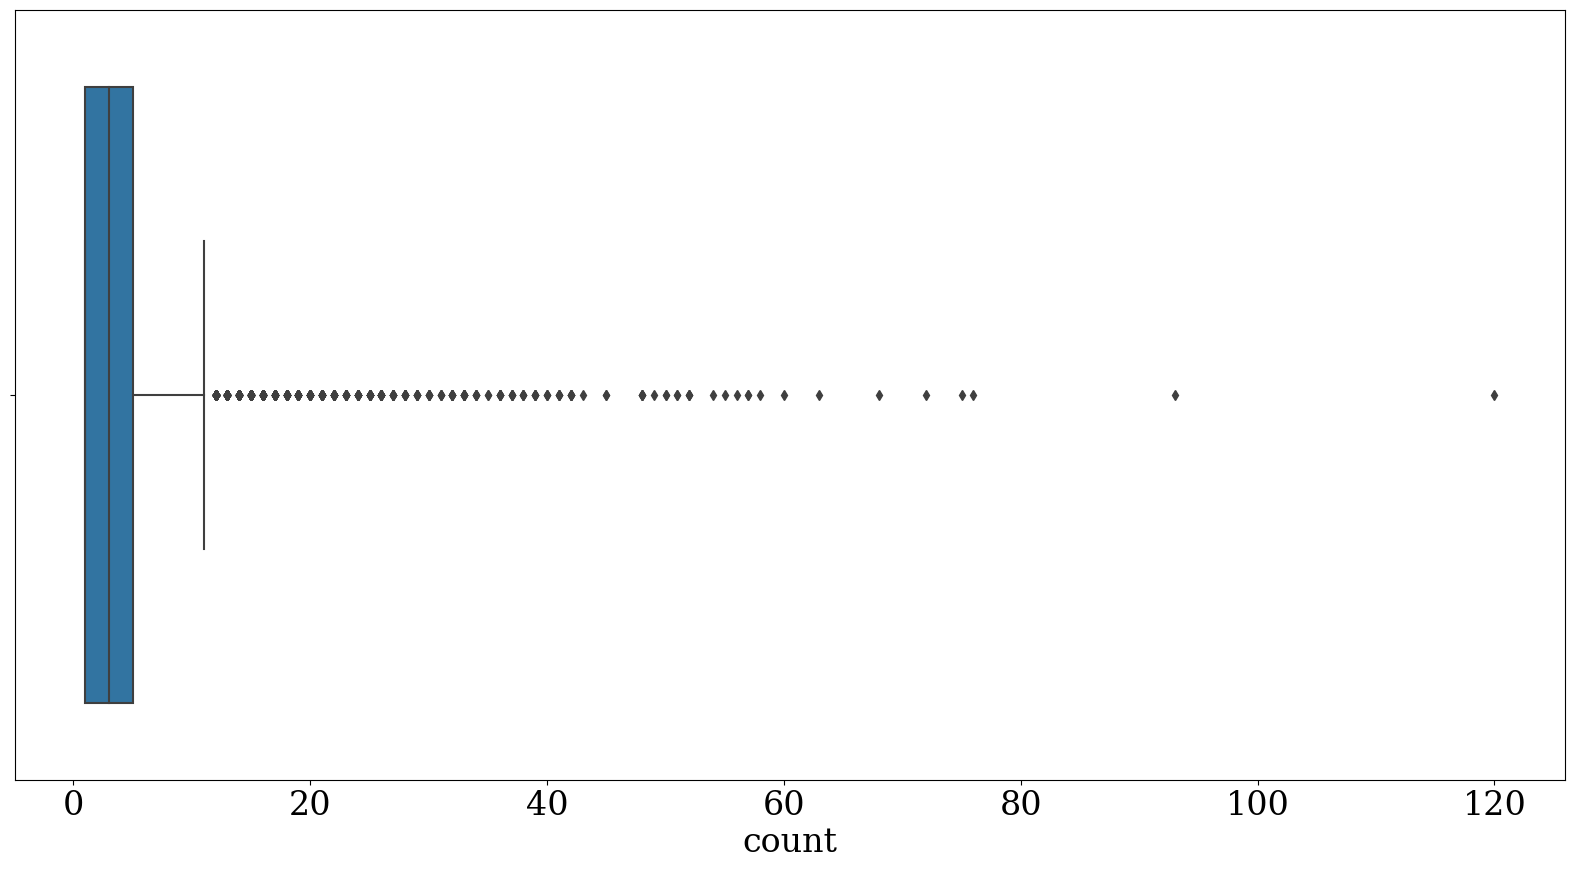

In [24]:
# how well does it work if we randomly pick one cds for each gene and use that to re-annotate?

# this can be run several times to get the distribution

df=pd.read_csv(clean_gtf_fname,sep="\t",names=definitions.gff3cols,comment="#")
cdf=df[df["type"]=="CDS"].reset_index(drop=True)
cdf["tid"]=cdf["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
cdf["gid"]=cdf["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]

rdf = cdf[~cdf["gid"].isnull()][["tid",
                               "gid"]].drop_duplicates(keep="first").groupby(by="gid").agg({"tid":["count",
                                                                                                         lambda grp: set(grp)]}).reset_index()
rdf.columns = ["gid","count","list"]

print("total number of genes with CDS in them: "+str(len(rdf)))
print("total number of transcript with CDS: "+str(rdf["count"].sum()))
print("number of genes with multiple coding isoforms: "+str(len(rdf[rdf["count"]>1])))
print("number of transcripts in genes with multiple coding isoforms: "+str(rdf[rdf["count"]>1]["count"].sum()))

mrdf = rdf[rdf["count"]>1].reset_index(drop=True)

sns.boxplot(rdf["count"])

In [25]:
num_rands = 10
percs = [0,0.25,0.50,0.75]
out_gtf_fname = gencode_outdir+"orf.gtf"

ref_gids = set(mrdf["gid"])

for p in percs:
    for i in range(num_rands):
        # for each gene get 1 random CDS and everything else
        ref_tids = set()
        q_tids = set()
        for idx,row in mrdf.iterrows():
            nrs = int(max(1,float(len(list(row["list"])))*p))
            rs = random.sample(list(row["list"]),nrs)
            for r in rs:
                ref_tids.add(r)
            for v in row["list"]:
                if v in rs:
                    continue
                else:
                    q_tids.add(v)

        rand_gtf_fname = out_gtf_fname.rsplit(".",1)[0]+".rand_"+str(int(p*100))+"."+str(i)+".gtf"

        with open(rand_gtf_fname,"w+") as outFP:
            with open(clean_gtf_fname,"r") as inFP:
                for line in inFP:
                    lcs = line.split("\t")
                    if not len(lcs) == 9:
                        continue

                    tid = lcs[8].split("transcript_id \"", 1)[1].split("\"", 1)[0]
                    if tid in ref_tids:
                        outFP.write(line)
                    else:
                        if tid in q_tids:
                            if not lcs[2]=="CDS":
                                outFP.write(line)

        rand_orf_gtf_fname = rand_gtf_fname.rsplit(".",1)[0]+".orf.gtf"

        cmd = [orfanage_bin,
               "--reference",fa_fname,
               "--query",rand_gtf_fname,
               "--threads",str(num_threads),
               "--output",rand_orf_gtf_fname,
               "--non_aug",
               "--keep_cds",
               rand_gtf_fname]
        print(" ".join(cmd))
        subprocess.call(cmd)

/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.0.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.0.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.0.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.1.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.1.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.1.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.2.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.2.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.2.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.3.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.3.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.3.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.4.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.4.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.4.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.5.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.5.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.5.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.6.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.6.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.6.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.7.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.7.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.7.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.8.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.8.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.8.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.9.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.9.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_0.9.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.0.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.0.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.0.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.1.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.1.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.1.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.2.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.2.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.2.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.3.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.3.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.3.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.4.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.4.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.4.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.5.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.5.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.5.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.6.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.6.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.6.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.7.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.7.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.7.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.8.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.8.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.8.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.9.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.9.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_25.9.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.0.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.0.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.0.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.1.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.1.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.1.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.2.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.2.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.2.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.3.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.3.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.3.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.4.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.4.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.4.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.5.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.5.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.5.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.6.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.6.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.6.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.7.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.7.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.7.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.8.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.8.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.8.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.9.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.9.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_50.9.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.0.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.0.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.0.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.1.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.1.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.1.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.2.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.2.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.2.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.3.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.3.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.3.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.4.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.4.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.4.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.5.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.5.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.5.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.6.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.6.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.6.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.7.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.7.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.7.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.8.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.8.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.8.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.9.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.9.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/gencode/orf.rand_75.9.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


In [26]:
# load reference chains
ref_df = definitions.get_chains(clean_gtf_fname,"CDS",True)

res = dict()
res_ilpd = pd.DataFrame()

for p in percs:
    for i in range(num_rands):
        rand_gtf_fname = out_gtf_fname.rsplit(".",1)[0]+".rand_"+str(int(p*100))+"."+str(i)+".gtf"
        rand_orf_gtf_fname = rand_gtf_fname.rsplit(".",1)[0]+".orf.gtf"

        # load orf and compare to red
        q_df = definitions.get_chains(rand_orf_gtf_fname,"CDS",False)
        q_adf = definitions.get_attribute(rand_orf_gtf_fname,"orfanage_template")
        q_df = q_df.merge(q_adf,on="tid",how='left')
        comp_df = q_df.merge(ref_df,on="tid",how="left")
        comp_df.columns = ["tid","orf_has_cds","orf_chain","orf_templ","ref_has_cds","seqid","strand","coords","ref_chain"]
        comp_df[["mod_chain",
                "c1len",
                "c2len",
                "match_start",
                "match_end",
                "num_bp_extra",
                "num_bp_missing",
                "num_bp_inframe",
                "num_bp_match",
                "num_bp_outframe",
                "lpd",
                "ilpd",
                "mlpd"]] = comp_df.apply(lambda row: definitions.compare_and_extract(row["orf_chain"],row["ref_chain"],row["strand"]),axis=1)
        comp_df.drop(["match_start","match_end","num_bp_match","lpd","mlpd"],axis=1,inplace=True)
        
        ilpd_df = comp_df[["ilpd"]].reset_index(drop=True)
        ilpd_df["perc"] = p
        ilpd_df["iter"] = i
        res_ilpd = pd.concat([res_ilpd,ilpd_df],axis=0)

        # get some numbers
        nmt = len(comp_df[(comp_df["ref_has_cds"]==1)&(comp_df["orf_has_cds"]==0)]) # number of missing CDS
        nmr = len(comp_df[comp_df["ref_chain"]==comp_df["orf_chain"]]) # number with matching chains
        nnr = len(comp_df[~(comp_df["ref_chain"]==comp_df["orf_chain"])]) # number with mis-matching chains
        mean_ilpd = comp_df["ilpd"].mean()

        res[str(i)+"."+str(p)] = [i,p,nmt,nmr,nnr,mean_ilpd]
        
res_ilpd.to_csv(out_gtf_fname.rsplit(".",1)[0]+".rand.ilpd.tsv",sep="\t",index=False)

res = pd.DataFrame.from_dict(res,orient="index").reset_index()
res.columns = ["idx","iter","perc","missing","matching","mismatching","mean_ilpd"]
res.drop("idx",axis=1,inplace=True)
res.to_csv(out_gtf_fname.rsplit(".",1)[0]+".rand.tsv",sep="\t",index=False)

In [27]:
res_ilpd = pd.read_csv(out_gtf_fname.rsplit(".",1)[0]+".rand.ilpd.tsv",sep="\t")
res = pd.read_csv(out_gtf_fname.rsplit(".",1)[0]+".rand.tsv",sep="\t")

res["ntxs"] = res["missing"]+res["mismatching"]+res["matching"]
res["missing%"] = (res["missing"].astype(float)/res["ntxs"].astype(float))*100.0
res["mismatching%"] = (res["mismatching"].astype(float)/res["ntxs"].astype(float))*100.0
res["matching%"] = (res["matching"].astype(float)/res["ntxs"].astype(float))*100.0

print("total")
for v in res.columns:
    print(v+": mean ",str(res[v].mean())+","+str(res[v].std()))
print("\n")
    
for p,grp in res.groupby(by="perc"):
    print(p)
    for v in res.columns:
        print(v+": mean ",str(grp[v].mean())+","+str(res[v].std()))
    print("\n")
res.head()

total
iter: mean  4.5,2.908872369413698
perc: mean  0.375,0.28306925853614895
missing: mean  531.075,520.011803983382
matching: mean  60517.95,3377.685225804113
mismatching: mean  7793.05,3374.9191591457757
mean_ilpd: mean  92.5988885503568,2.9925599924253814
ntxs: mean  68842.075,517.466430844825
missing%: mean  0.7659675425529693,0.7466699823835754
mismatching%: mean  11.287083546334244,4.819722023756366
matching%: mean  87.9469489111128,5.52698620685744


0.0
iter: mean  4.5,2.908872369413698
perc: mean  0.0,0.28306925853614895
missing: mean  1314.2,520.011803983382
matching: mean  56439.6,3377.685225804113
mismatching: mean  11868.6,3374.9191591457757
mean_ilpd: mean  89.06170785601608,2.9925599924253814
ntxs: mean  69622.4,517.466430844825
missing%: mean  1.8875797050888927,0.7466699823835754
mismatching%: mean  17.047072002068408,4.819722023756366
matching%: mean  81.0653482928427,5.52698620685744


0.25
iter: mean  4.5,2.908872369413698
perc: mean  0.25,0.28306925853614895
missi

,iter,perc,missing,matching,mismatching,mean_ilpd,ntxs,missing%,mismatching%,matching%
0,0,0.0,1302,56572,11738,89.124213,69612,1.870367,16.862035,81.267598
1,1,0.0,1280,56629,11681,89.256888,69590,1.839345,16.785458,81.375198
2,2,0.0,1289,56325,11985,89.014141,69599,1.852038,17.220075,80.927887
3,3,0.0,1248,56368,11940,89.104424,69556,1.794238,17.166024,81.039738
4,4,0.0,1347,56477,11831,89.132459,69655,1.933817,16.985141,81.081042


In [29]:
res

,iter,perc,missing,matching,mismatching,mean_ilpd
0,0,0.00,1302,56572,11738,89.124213
1,1,0.00,1280,56629,11681,89.256888
2,2,0.00,1289,56325,11985,89.014141
3,3,0.00,1248,56368,11940,89.104424
4,4,0.00,1347,56477,11831,89.132459
5,5,0.00,1376,56283,12025,88.799277
6,6,0.00,1339,56381,11923,88.931424
7,7,0.00,1334,56577,11733,89.124418
8,8,0.00,1271,56517,11793,89.133904
9,9,0.00,1356,56267,12037,88.995930


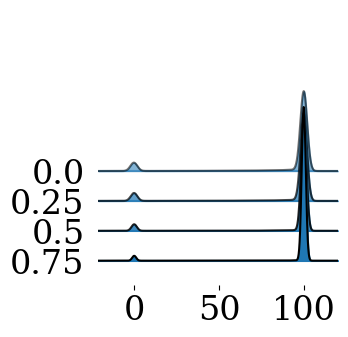

In [28]:
res_ilpd = pd.read_csv(out_gtf_fname.rsplit(".",1)[0]+".rand.ilpd.tsv",sep="\t")
res = pd.read_csv(out_gtf_fname.rsplit(".",1)[0]+".rand.tsv",sep="\t")

joyplot(res_ilpd[["perc","ilpd"]],by='perc',column='ilpd',figsize=(4,4),fade=True)
plt.show()